# "How to train your ResNet: Part 1" in fastai v1

The goal of this notebook is to reproduce the results of the great article series called "How to train your ResNet" [Part 1](https://myrtle.ai/how-to-train-your-resnet-1-baseline/) by myrtle.ai. If all goes well, I might implement the entire article series, but we are starting with Part 1 for now.

You can find the code for the experiments corresponding to the diffferent parts of the article series here: https://github.com/davidcpage/cifar10-fast/blob/master/experiments.ipynb.

# Setup

Install & import fastai and download the CIFAR-10 dataset.

In [1]:
# !pip install fastai

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# set NVidia Tesla V100 GPU clock speed to the maximum
!sudo nvidia-persistenced
!sudo nvidia-smi -ac 877,1530

Applications clocks set to "(MEM 877, SM 1530)" for GPU 00000000:00:04.0
All done.


In [3]:
from fastai.callbacks import * 
from fastai.vision import *

In [4]:
path = untar_data(URLs.CIFAR)

# Transforms

The below is supposed to give us the same transforms as in the Part 1: Baseline  experiment, namely `[Crop(32, 32), FlipLR()]`.

In [5]:
crop = rand_resize_crop(32, ratios=(1.,1.))

In [6]:
crop

[RandTransform(tfm=TfmCoord (zoom_squish), kwargs={'scale': (1.0, 2.0, 8), 'squish': (1.0, 1.0, 8), 'invert': (0.5, 8), 'row_pct': (0.0, 1.0), 'col_pct': (0.0, 1.0)}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmPixel (crop), kwargs={'size': 32}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)]

In [7]:
tfms = get_transforms(max_rotate=0., max_zoom=0., max_lighting=0., max_warp=0., xtra_tfms=[*crop])

In [8]:
tfms[0] # train set transforms

[RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmCoord (zoom_squish), kwargs={'scale': (1.0, 2.0, 8), 'squish': (1.0, 1.0, 8), 'invert': (0.5, 8), 'row_pct': (0.0, 1.0), 'col_pct': (0.0, 1.0)}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmPixel (crop), kwargs={'size': 32}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)]

TODO: check if the transforms are actually identical

# create databunch

In [9]:
batch_size = 128

In [10]:
data = ImageDataBunch.from_folder(path, valid='test', bs=batch_size, ds_tfms=tfms)

In [11]:
cifar_stats = ([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])

In [12]:
data.normalize(cifar_stats)

ImageDataBunch;

Train: LabelList (50000 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
horse,horse,horse,horse,horse
Path: /home/jupyter/.fastai/data/cifar10;

Valid: LabelList (10000 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
horse,horse,horse,horse,horse
Path: /home/jupyter/.fastai/data/cifar10;

Test: None

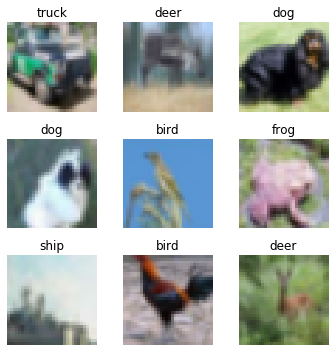

In [13]:
data.show_batch(rows=3, figsize=(5,5))

# reproduce the architecture

Custom resnet variant: ![ResNet18 variant graph](https://296830-909578-raikfcquaxqncofqfm.stackpathdns.com/wp-content/uploads/2019/06/Artboard-1-5.svg)

In [14]:
def conv(ni, nf, ks=3, stride=1, padding=None, bias=False):
    if padding is None: padding = ks//2
    return nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=padding, bias=bias)

def noop(x): return x
  
class ResBlock(Module):
    def __init__(self, c_in, c_out, stride=1):
        self.bn1   = nn.BatchNorm2d(c_in)
        self.relu1 = nn.ReLU(True)
        self.branch = nn.Sequential(
            conv(c_in, c_out, ks=3, stride=stride, padding=1),
            nn.BatchNorm2d(c_out),
            nn.ReLU(True),
            conv(c_out, c_out, ks=3, stride=1, padding=1)
        )
        projection = (stride != 1) or (c_in != c_out)
        self.idconv = noop if not projection else conv(c_in, c_out, ks=1, stride=stride, padding=0)

    def forward(self, x):
      _out = self.relu1(self.bn1(x))
      return self.branch(_out) + self.idconv(_out)

class Pool(Module):
  def __init__(self, concat=True):
    self.concat = concat
    self.maxpool = nn.MaxPool2d(4)
    if concat:
      self.avgpool = nn.AvgPool2d(4)
    
  def forward(self, x):
    if self.concat:
      return torch.cat([self.maxpool(x), self.avgpool(x)], 1)
    return self.maxpool(x)

def make_DAWN_Net(c=64, Block=ResBlock, prep_bn_relu=False, concat_pool=True):
  if isinstance(c, int):
    c = [c, 2*c, 4*c, 4*c]
  layers = [conv(3, c[0], ks=3, stride=1, padding=1)]
  if prep_bn_relu:
    layers.append(nn.BatchNorm2d(c[0]))
    layers.append(nn.ReLU(True))
  layers.append(nn.Sequential(
    Block(c[0], c[0], 1),
    Block(c[0], c[0], 1)
  ))
  layers.append(nn.Sequential(
    Block(c[0], c[1], 2),
    Block(c[1], c[1], 1)
  ))
  layers.append(nn.Sequential(
    Block(c[1], c[2], 2),
    Block(c[2], c[2], 1)
  ))
  layers.append(nn.Sequential(
    Block(c[2], c[3], 2),
    Block(c[3], c[3], 1)
  ))
  layers.append(nn.Sequential(
    Pool(concat=concat_pool),
    Flatten(),
    nn.Linear(2*c[3] if concat_pool else c[3], 10, bias=True),
  ))
  return nn.Sequential(*layers)

In [15]:
model = make_DAWN_Net(); model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): Sequential(
    (0): ResBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace)
      (branch): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
    )
    (1): ResBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace)
      (branch): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
        (3): Conv2d(

TODO: find a way to test if the model is actually idendical at the PyTorch level

# reproduce optimizer

In [16]:
opt = partial(optim.SGD, lr=1e-3, momentum=0.9, weight_decay=5e-4*batch_size, nesterov=True)

TODO: make sure the optimizer is actually identical

# create learner

TODO: find a way to use `nn.CrossEntropyLoss` as loss function like in Part 1

In [17]:
learn = Learner(data, model, metrics=accuracy, loss_func=CrossEntropyFlat(), opt_func=opt, callback_fns=[ShowGraph])

# learning rate schedule

lr_schedule from the bag of tricks article:

In [18]:
class PiecewiseLinear(namedtuple('PiecewiseLinear', ('knots', 'vals'))):
    def __call__(self, t):
        return np.interp([t], self.knots, self.vals)[0]

sched = PiecewiseLinear([0, 15, 30, 35], [0, 0.1, 0.005, 0])

In [19]:
import matplotlib.pyplot as plt

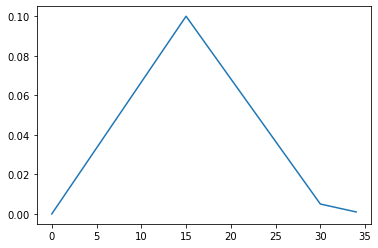

In [20]:
plt.plot([sched(o) for o in range(35)])

So this is basically the one cycle scheduler.

TODO: make sure it is actually the learning rate scheduler

# half precision training

In [21]:
learn.to_fp16();

# learning rate

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


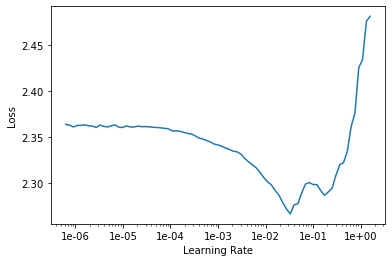

In [23]:
learn.recorder.plot()

In [24]:
# lr = 1e-2
lr = 1e-1

# training

In [25]:
learn.fit_one_cycle(35, max_lr=lr)

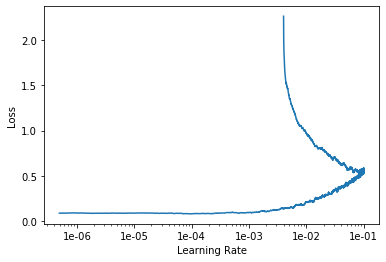

In [26]:
learn.recorder.plot()

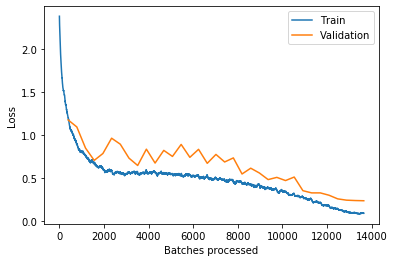

In [27]:
learn.recorder.plot_losses()

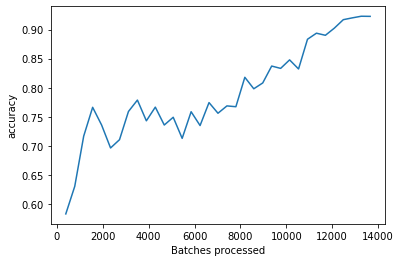

In [28]:
learn.recorder.plot_metrics()

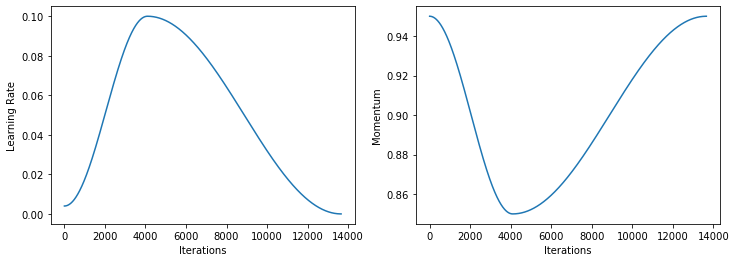

In [30]:
learn.recorder.plot_lr(show_moms=True)